<a href="https://colab.research.google.com/github/poojamahajan0712/medium_blog/blob/master/BN/MNIST_with_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
#1. Import libraries 
#!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
# 2. Loading and transforming dataset 
#Transformations
#Transforms are common image transformations. They can be chained together using Compose
transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  
                                      
                                       ])


train = datasets.MNIST('./data', train=True, download=True, transform=transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=transforms)

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#you have to use data loader in PyTorch that will actually read the data within batch size and put into memory
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


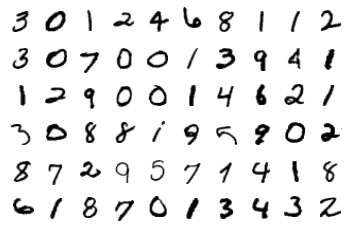

In [ ]:
#3 View few images from train data 
# loading one set of train data batch 

dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
#4 Building network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26  RF 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) # output_size = 22 RF 7 Jout - 1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF 8 Jout - 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 11  RF 8 Jout- 2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 9  RF - 12 ,Jout - 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7 RF - 16  Jout - 2

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7  RF - 16  Jout - 2 


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            #nn.BatchNorm2d(10),NEVER!
            # nn.ReLU() NEVER!
        ) # output_size = 1  RF -28  Jout - 2 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
#5 Model Summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Model Summary")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,608
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 64, 22, 22]          18,432
       BatchNorm2d-8           [-1, 64, 22, 22]             128
              ReLU-9           [-1, 64, 22, 22]               0
        MaxPool2d-10           [-1, 64, 11, 11]               0
           Conv2d-11           [-1, 32, 11, 11]           2,048
      BatchNorm2d-12           [-1, 32, 11, 11]              64
             ReLU-13           [-1, 32, 11, 11]               0
           Conv2d-14

In [ ]:
#6 training the network 
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)




  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.016860438510775566 Batch_id=468 Accuracy=95.68: 100%|██████████| 469/469 [00:19<00:00, 23.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.018538009375333786 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.007293585687875748 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.010815641842782497 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.009954646229743958 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.013275058008730412 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.04263373836874962 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.0026409721467643976 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.014619730412960052 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.029683636501431465 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]



Test set: Average loss: 0.0219, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

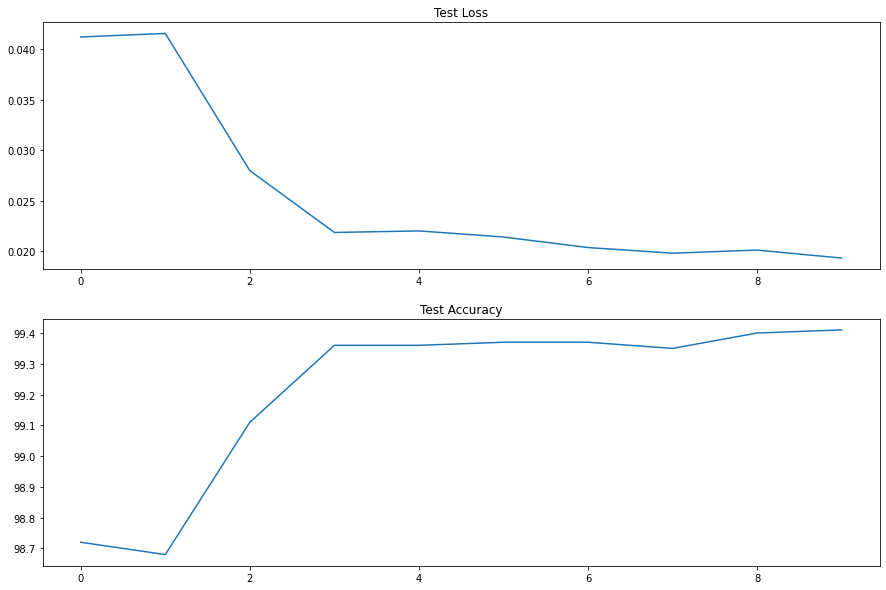

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(15,10))

axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")